# LAB 2.1 - CNS (Hebbian learning)

Import of libraries and fixing of random seed.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

np.random.seed(10)

Dataset loading and plot in a scatter plot.

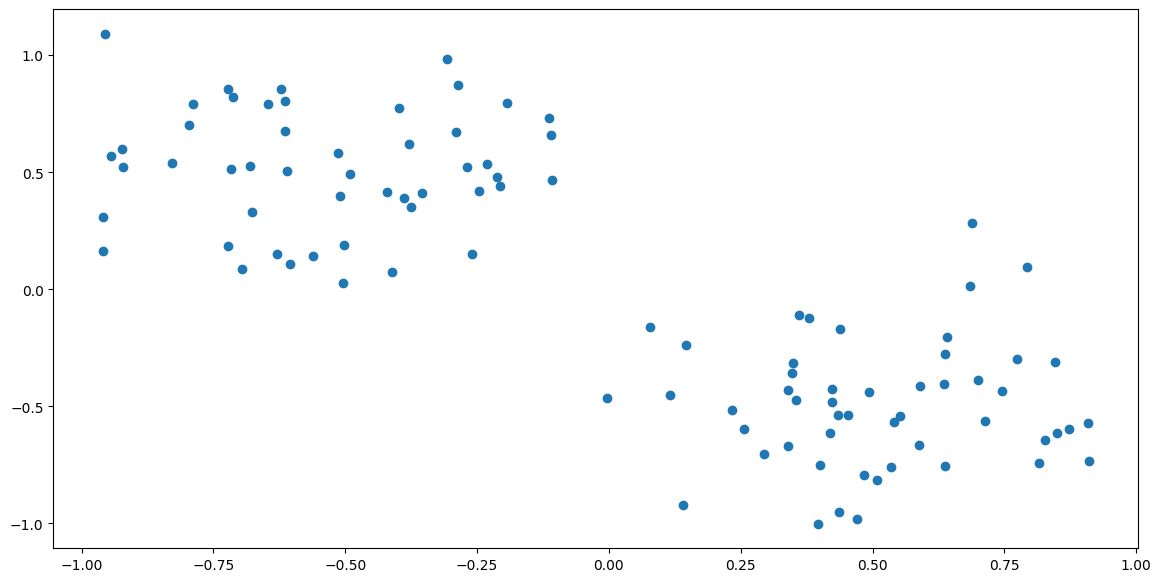

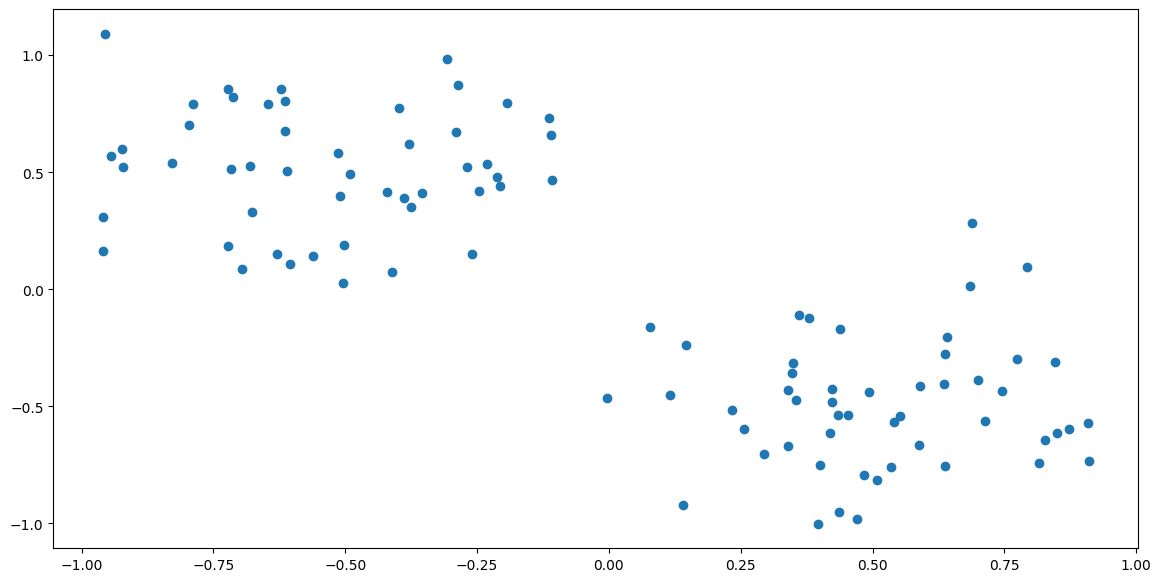

In [11]:
data = pd.read_csv('lab2_1_data.csv', header=None).to_numpy()

plt.figure(figsize=(14, 7))
plt.scatter(data[0], data[1])
plt.show()

Principal Component Analysis of dataset from the correlation matrix and visualization of first principal component (eigenvector related to the biggest eigenvalue).

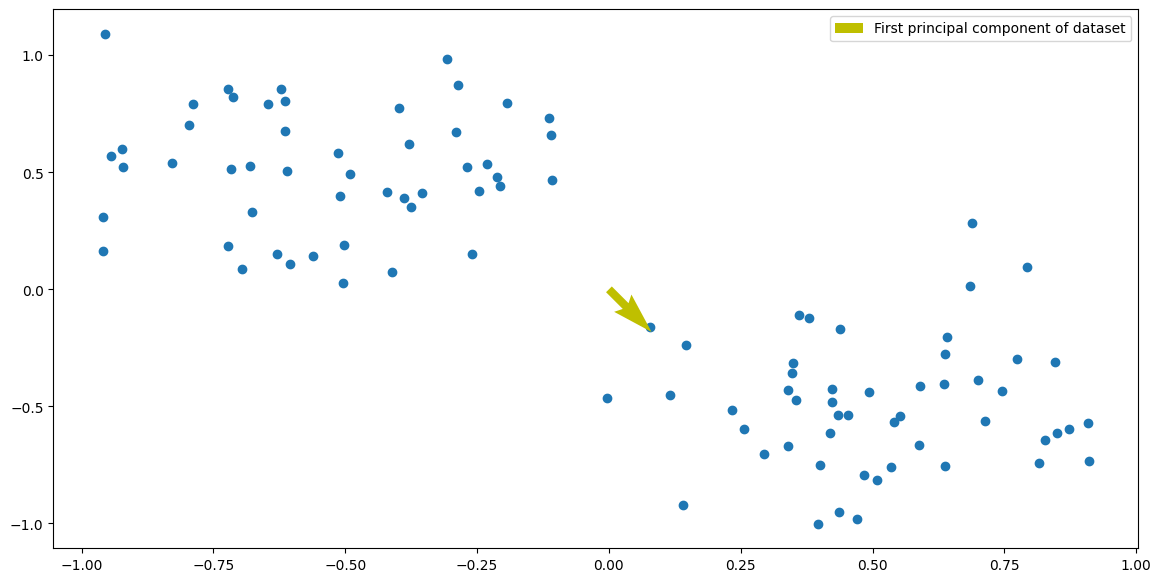

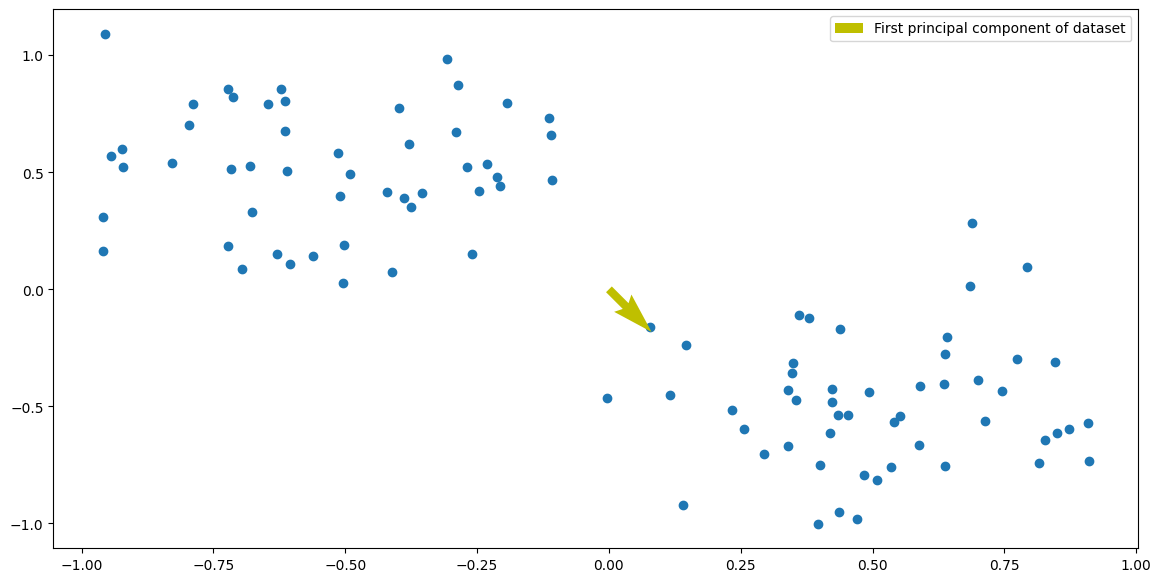

In [12]:
C = np.corrcoef(data)
eig_vals, eig_vects = np.linalg.eig(C)
first_pc = eig_vects.T[eig_vals.argmax()]

plt.figure(figsize=(14, 7))
plt.scatter(data[0], data[1])
plt.quiver(*first_pc, color='y', label='First principal component of dataset')
plt.legend()
plt.show()

Weights vector initialization and visualization in data plot.

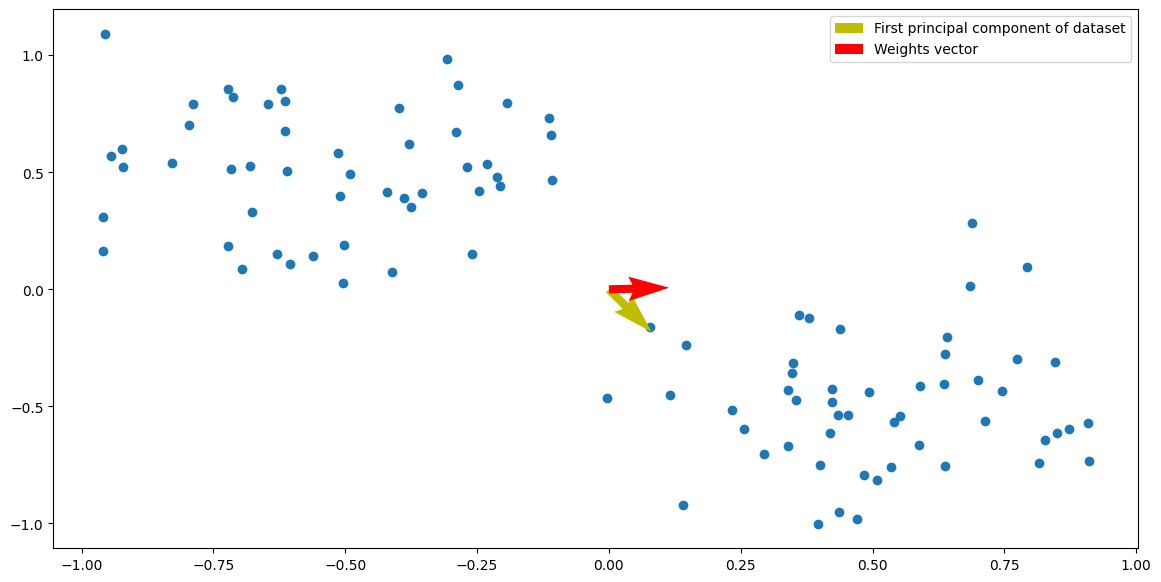

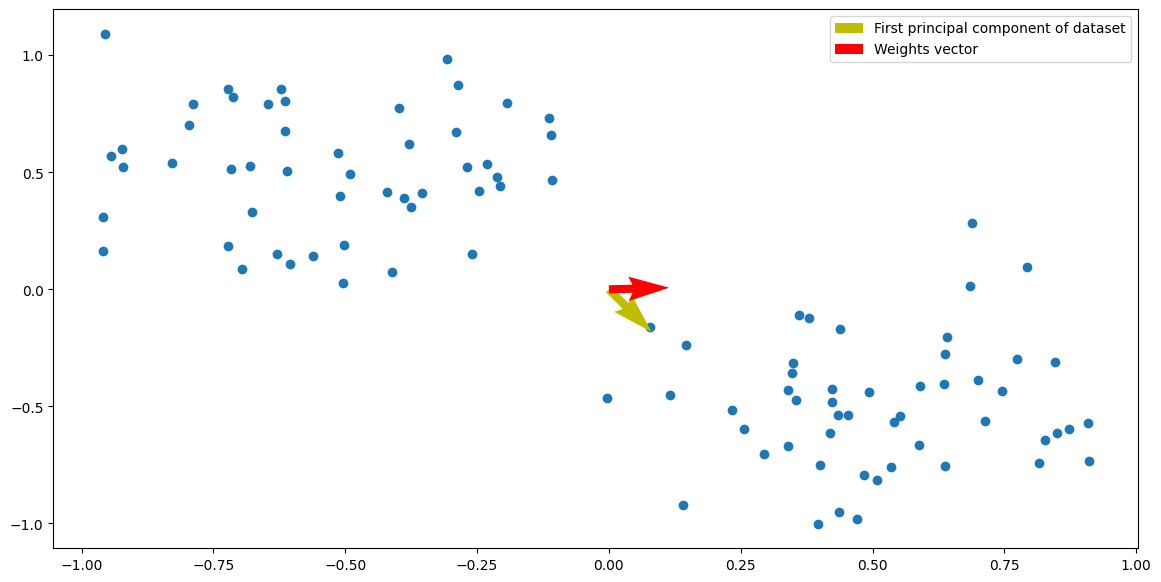

In [13]:
W = np.random.rand(data.shape[0])

plt.figure(figsize=(14, 7))
plt.scatter(data[0], data[1])
plt.quiver(*first_pc, color='y', label='First principal component of dataset')
plt.quiver(*W, color='r', label='Weights vector')
plt.legend()
plt.show()

Function able to plot the analysis on weights vector. This function is able to show 4 plots:
1 - Scatter plot of data distribution with first principal component eigenvector and weights vector.
2 - Change of weights norm over time.
3 - Change of first weights vector component (x) over time.
4 - Change of second weights vector component (y) over time.

In [14]:
def plot_analysis(weights_list: list[np.array], title: str, save: bool = True):
    plt.figure(figsize=(20, 20))
    plt.suptitle(title)

    ax = plt.subplot(3, 2, 1)
    ax.set_title('Data distribution, W and first component of PCA')
    ax.scatter(*data)
    ax.quiver(*first_pc, color='y')
    ax.quiver(*weights_list[-1], color='r')

    x = list(range(len(weights_list)))
    ax = plt.subplot(3, 2, 2)
    ax.set_title('W norm')
    plt.grid(True)
    ax.plot(x, [np.linalg.norm(w) for w in weights_list])

    ax = plt.subplot(3, 2, 3)
    ax.set_title('W first component - x axis')
    plt.grid(True)
    ax.plot(x, [w[0] for w in weights_list])

    ax = plt.subplot(3, 2, 4)
    ax.set_title('W second component - y axis')
    plt.grid(True)
    ax.plot(x, [w[1] for w in weights_list])

    if save:
        plt.savefig(f'hebbian_learning_plots/{title}.png')

Function able to train the weights vector given a learning rule and collect the list weights vector values over time.

In [19]:
def train(dataset: np.array, w: np.array, learning_rule: Callable, epochs: int = 500, lr: float = 1e-3,
          weights_threshold: float = 1e-10):
    weights_list = [w]
    for epoch in range(epochs):
        dataset = np.random.permutation(dataset.T).T
        for u in data.T:
            v = w.T @ u
            delta_w = learning_rule(v, u, w)
            w_new = w + lr * delta_w
            if np.linalg.norm(w_new - w) < weights_threshold:
                return weights_list
            else:
                w = w_new
            weights_list.append(w)
    return weights_list

## Assignment 1 - Basic Hebbian learning

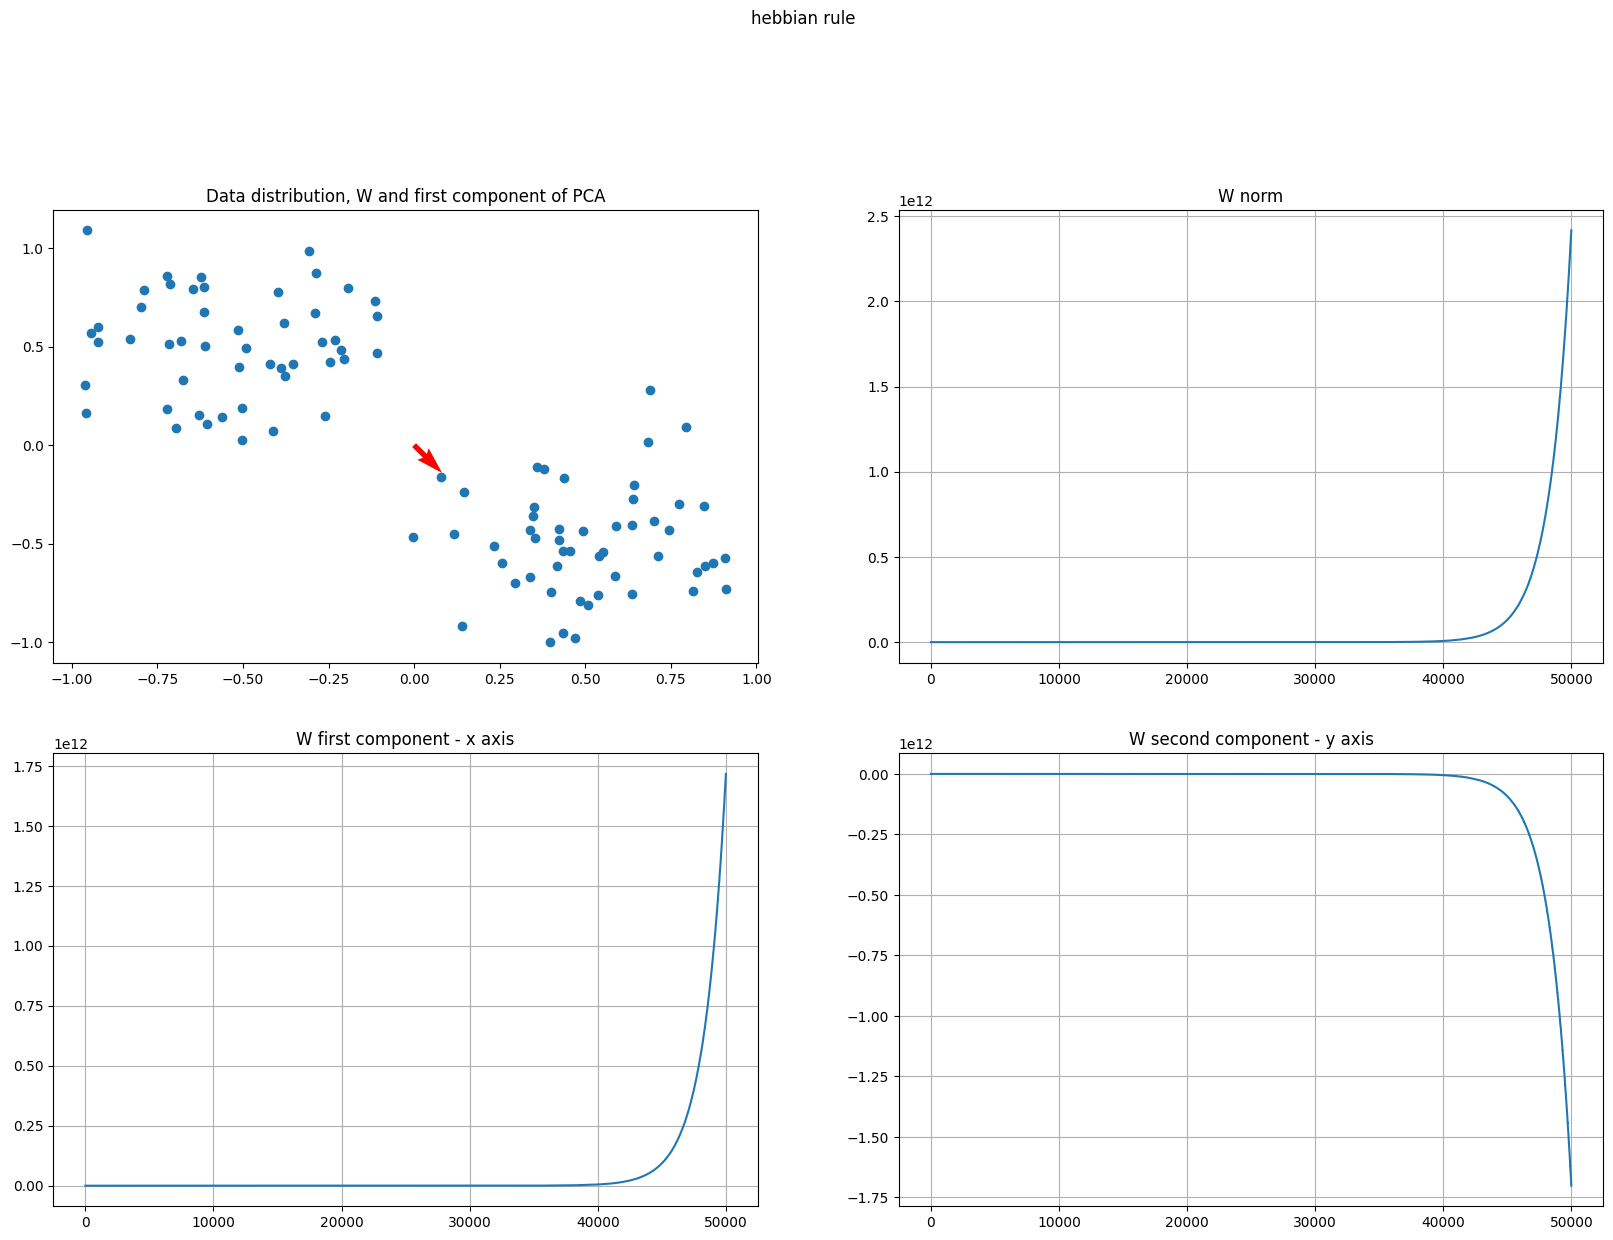

In [20]:
basic_hebbian_rule = lambda v, u, w: v * u

weights_over_time = train(data, W, learning_rule=basic_hebbian_rule)
plot_analysis(weights_over_time, title='hebbian rule')

## Assignment 2 - Oja rule

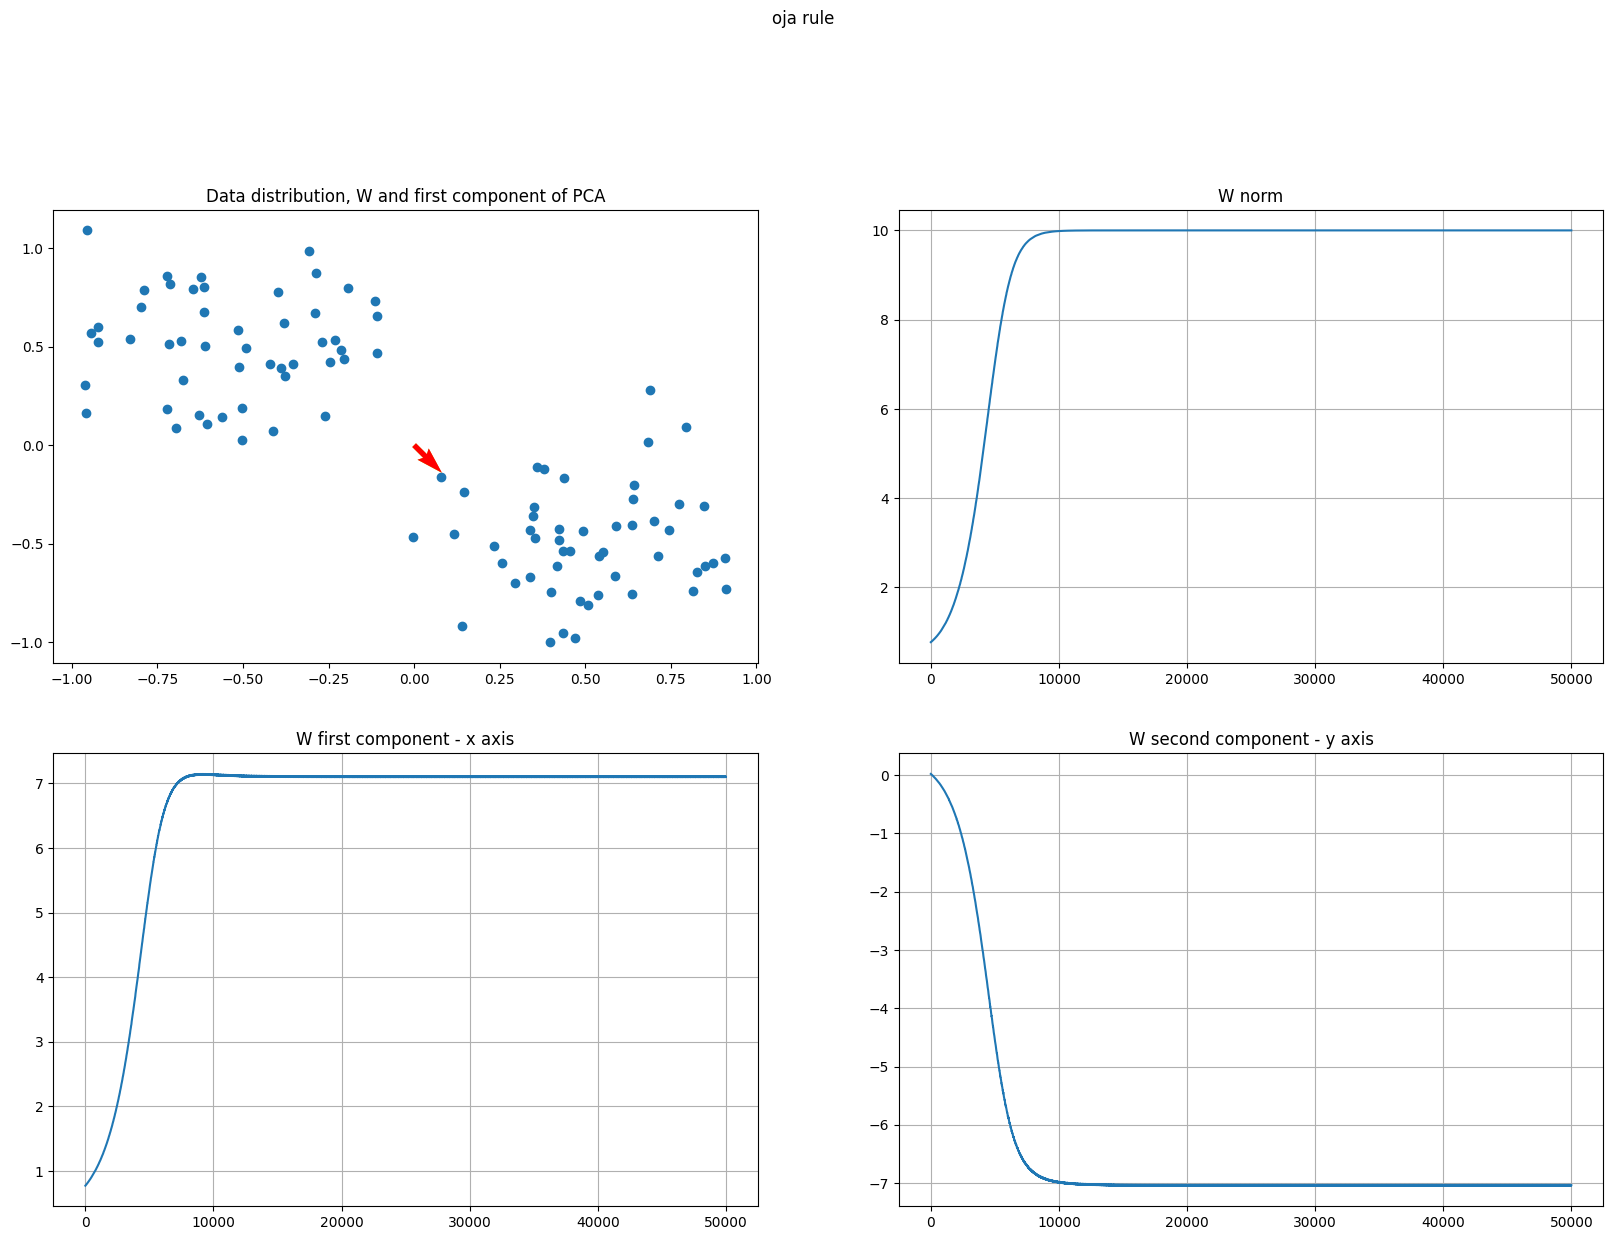

In [21]:
alpha = 0.01
oja_rule = lambda v, u, w: v * u - alpha * v ** 2 * w

weights_over_time = train(data, W, learning_rule=oja_rule)
plot_analysis(weights_over_time, title='oja rule')

## Assignment 3 - Subtractive normalization

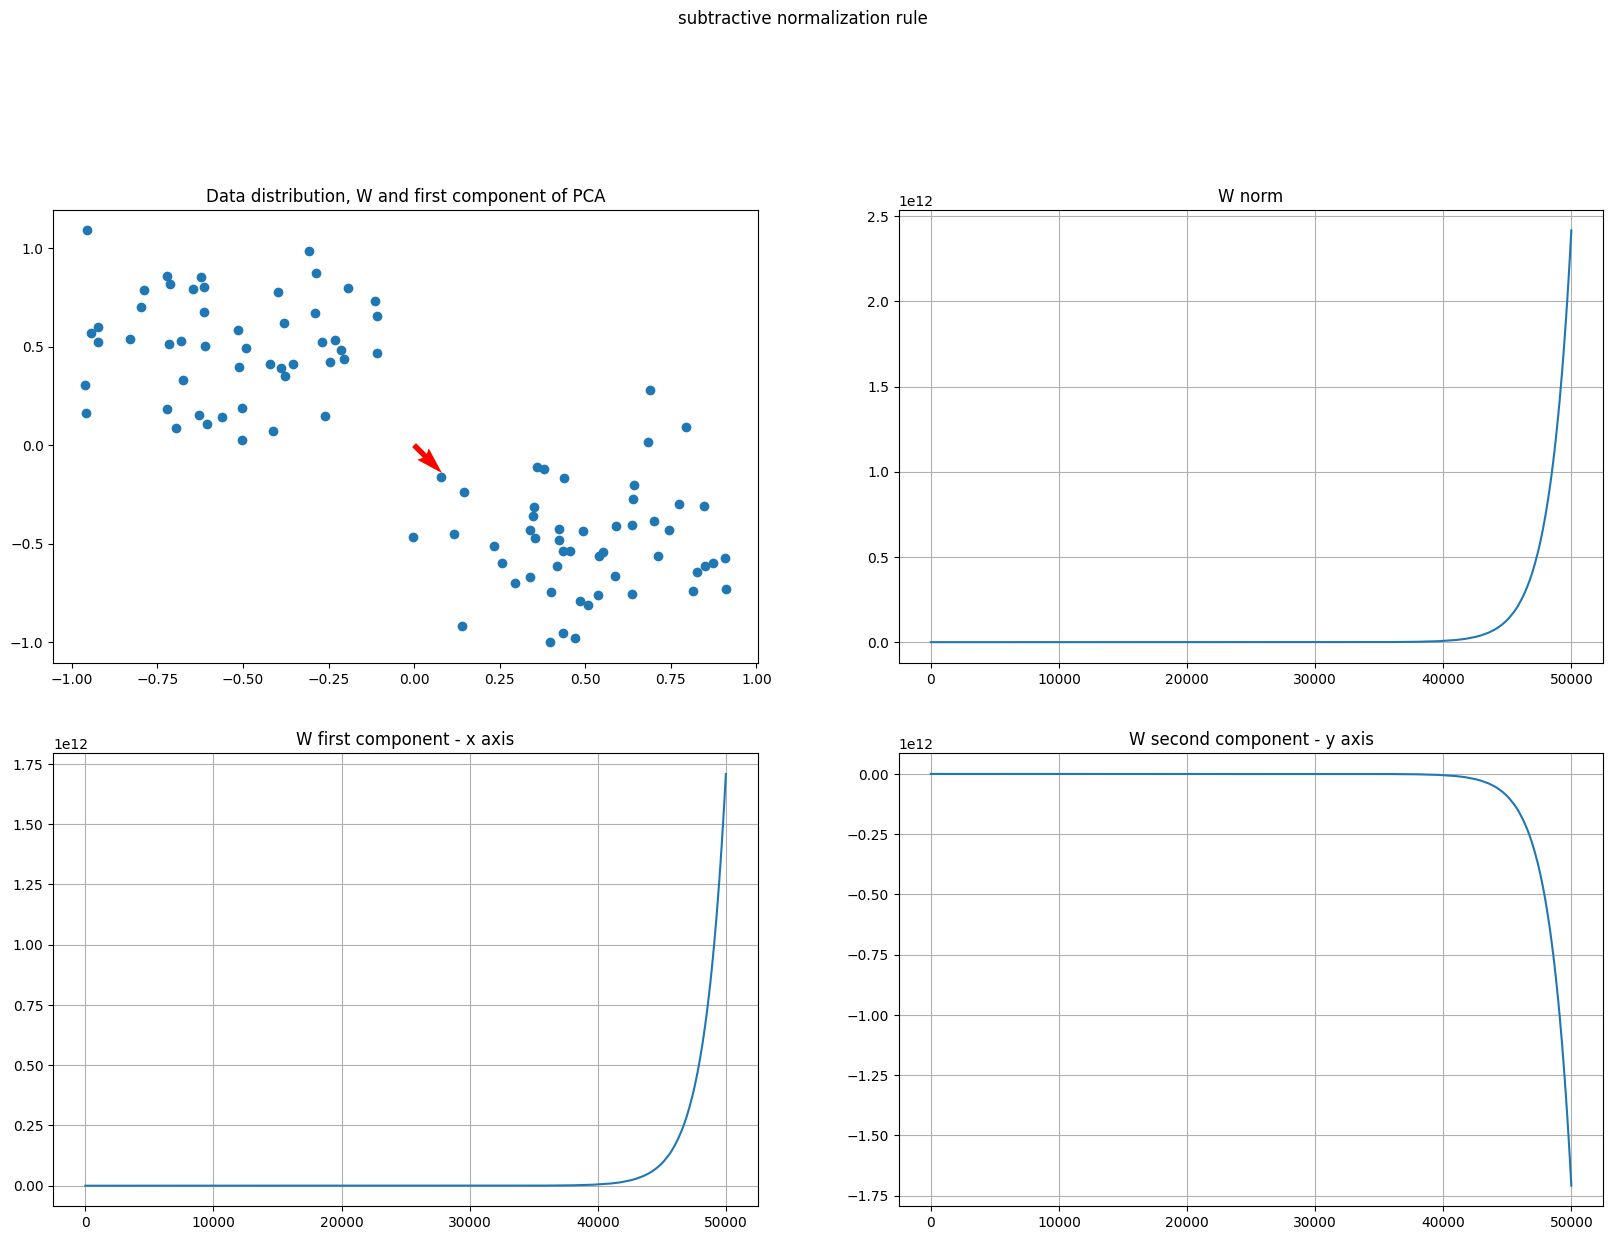

In [22]:
n = np.ones(data.shape[0])
subtractive_normalization = lambda v, u, w: v * u - ((v * (n.T @ u) * n) / 2)

weights_over_time = train(data, W, learning_rule=subtractive_normalization)
plot_analysis(weights_over_time, title='subtractive normalization rule')